# Dispersion Analysis: Fornberg vs. DRP Stencils

In [1]:
import numpy as np
import scipy as sp
import sympy as sym
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from functools import partial
from matplotlib import patheffects
from numpy import linalg as la

In [2]:
from devito import Grid, Function, TimeFunction, SparseTimeFunction, Eq, Operator, solve

In [3]:
normtype  = 2

## 1. Problem Setup

In [4]:
def ricker(t, f=10, A=1):
    trm = (np.pi * f * (t - 1 / f)) ** 2
    return A * (1 - 2 * trm) * np.exp(-trm)

In [5]:
f0      = 30
extent  = 1000
vval    = 1500
t1      = 0.6
npoints = 201
h       = extent/(npoints-1)

In [6]:
def critical_dt(weights,h,vmax):
    
    a = (h/vmax)*np.sqrt(2/np.sum([np.abs(a) for a in weights]))
    
    return float(a)

In [7]:
def critical_h(weights,dt,vmax):

    a = np.sqrt(2/np.sum([np.abs(a) for a in weights]))/(vmax*dt)
    b = 1/a
    
    return float(b)

In [8]:
def acoustic(weights,h,dt,v,f,extent,t1,factor=1):

    origin = (0., 0.)
    grid_extent = (extent, extent)
    sn = int(np.ceil((grid_extent[0] - origin[0])/h))+1
    shape = (sn, sn)

    t0 = 0
    tn = int(np.ceil((t1 - t0)/dt))

    r = v*dt/h

    weights = np.concatenate([weights[::-1], weights[1:]])
    space_order = len(weights) - 1

    sx = grid_extent[0]/2 - origin[0]
    sy = grid_extent[1]/2 - origin[1]

    grid = Grid(shape=shape, extent=grid_extent)
    x, y = grid.dimensions

    velocity = Function(name="velocity", grid=grid, space_order=space_order)
    velocity.data[:] = v

    t = np.linspace(t0, t1, tn)
    source = SparseTimeFunction(
        name="ricker",
        npoint=1,
        coordinates=[(sx, sy)],
        nt=tn,
        grid=grid,
        time_order=2,
        space_order=space_order
    )
    source.data[:, 0] = ricker(t, f=f)

    nrecv = 101
    rx = np.linspace(origin[0], grid_extent[0], nrecv)
    ry = 0.02*grid_extent[1]*np.ones(nrecv)
    receiver = SparseTimeFunction(
        name="recv",
        npoint=nrecv,
        coordinates=np.array([rx, ry]).T,
        nt=tn,
        grid=grid
    )

    u = TimeFunction(name="u", grid=grid, time_order=2, space_order=space_order)

    pde = (1/velocity**2)*u.dt2 - u.dx2(weights=weights) - u.dy2(weights=weights)
    stencil = Eq(u.forward, solve(pde, u.forward))

    src_term = source.inject(field=u.forward, expr=source*factor*factor*velocity*velocity*dt*dt)
    recv_term = receiver.interpolate(expr=u.forward)
    op = Operator([stencil] + src_term + recv_term, subs=grid.spacing_map)
    op(time=tn - 1, dt=dt)

    return u.data[-1], receiver.data, r

In [9]:
def plot_wave(u, ax, clip, extent, hline,r): 
    extents=(0, extent, 0, extent)
    ax.imshow(
        u.T,
        extent=extents,
        cmap='seismic',
        vmin=-clip,
        vmax=clip
    )
    ax.invert_yaxis()
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f'{r = :.3g}')
    len(hline) == 4
    ax.plot(
        (hline[0], hline[2]),
        (hline[1], hline[3]),
        'g--', lw=2
    )

In [10]:
def plot_profile(array,ax,clip,extent,first_arrival):
    
    axis_labels=('x', 'A')
    
    ax.plot(np.linspace(extent[0], extent[1], array.size), array)
    ax.set_xlim(extent)
    ax.set_ylim((-clip, clip))
    ax.set_aspect((extent[1] - extent[0])/(2*clip))
    
    if first_arrival is not None:
        ax.axvline(first_arrival, c='red', ls='--', lw=1)
        ax.annotate(f'first arrival',
            xy=(first_arrival, 0), xycoords='data',
            xytext=(-70, 5), textcoords='offset points', fontsize=12, color='red'
        )
    
    ax.set_xlabel(axis_labels[0])
    ax.set_ylabel(axis_labels[1])

In [11]:
def plot_shot(data, ax, clip,extent,t1,vline,r,first_arrival):
    
    extents=(0,extent,0,t1)
    
    ax.imshow(
        data[::-1,:],
        extent=extents,
        vmin=-clip,
        vmax=clip,
        cmap='grey',
        aspect=(extents[1] - extents[0])/(extents[3] - extents[2]),
    )
    ax.invert_yaxis()
    ax.set_xlabel('x')
    ax.set_ylabel('t')

    arrival = None
    
    if isinstance(first_arrival, np.ndarray) or first_arrival:
        time = np.linspace(extents[2], extents[3], data.shape[0])
        space = np.linspace(extents[0], extents[1], data.shape[1])
        if not isinstance(first_arrival, np.ndarray):
            arrival = time[np.argmax(np.abs(data)>0.01, axis=0)]
            ax.plot(space, arrival, c='red', lw=1)
            ax.annotate(f'first arrival',
                xy=((extents[1] - extents[0])/2, arrival[arrival.size//2]), xycoords='data',
                xytext=(5, 5), textcoords='offset points', fontsize=12, color='red',
                path_effects=[patheffects.withStroke(linewidth=2, foreground="k")]
            )
        else:
            ax.plot(space, first_arrival, c='red', lw=1)
    
    ax.set_title(f'{r = :.3g}')
    assert len(vline) == 4
    ax.plot(
        (vline[0], vline[2]),
        (vline[1], vline[3]),
        'g--', lw=2
    )
    
    return arrival

In [12]:
def critical_cfl(weights,h,dt,vmax):

    limit  = np.sqrt(2/np.sum([np.abs(a) for a in weights]))
    rvalue = (dt*vmax)/h

    print('Limit Value: %f'%limit)
    print('RVALUE: %f'%rvalue)
    
    if(limit>rvalue): 
        
        print('Stable Choice of weights,h,dt and vel!')
        print('')

    else:

        print('WARNING!"')
        print('Unstable Choice of weights, h,dt and vel!')
        print('')
        
    return

In [13]:
dtlist = []

for k1 in range(0,10):

    M = k1+1
    N = 2
    x = [(1-(-1)**n*(2*n+1))//4 for n in range(2*M + 1)]
    weights = sym.finite_diff_weights(N, x, 0)
    fornberg = np.array(weights[-1][-1][::2], dtype=np.float64)
    dtnew1 = critical_dt(fornberg,h,vval)
    dtlist.append(dtnew1)

vdtlist = np.array(dtlist)
dtnew   = np.amin(vdtlist)
dtnew

np.float64(0.0020311336882842547)

In [14]:
dtnew = 10**(-3)

In [15]:
M = 10
x = [(1-(-1)**n*(2*n+1))//4 for n in range(2*M + 1)]
N = 2
weightsref  = sym.finite_diff_weights(N, x, 0)
fornbergref = np.array(weightsref[-1][-1][::2], dtype=np.float64)
critical_cfl(fornbergref,h/16,dtnew/16,vval)

Limit Value: 0.609340
RVALUE: 0.300000
Stable Choice of weights,h,dt and vel!



In [16]:
uref,dataref,rref = acoustic(fornbergref,h/16,dtnew/16,vval,f0,extent,t1,factor=16)

Operator `Kernel` ran in 167.99 s


In [17]:
mvalues  = [1,2,3,4,5,6,7,8,9,10]
nmavlues = len(mvalues)

## 2. Fornberg

In [18]:
luf   = []
lrecf = []
lrf   = []

for k1 in range(0,nmavlues):

    M = k1 + 1
    x = [(1-(-1)**n*(2*n+1))//4 for n in range(2*M + 1)]
    N = 2
    weights     = sym.finite_diff_weights(N, x, 0)
    fornberg    = np.array(weights[-1][-1][::2], dtype=np.float64)
    uf,dataf,rf = acoustic(fornberg,h,dtnew,vval,f0,extent,t1)

    luf.append(uf)
    lrecf.append(dataf)
    lrf.append(rf)
    critical_cfl(fornberg,h,dtnew,vval)

Operator `Kernel` ran in 0.01 s


Limit Value: 0.816497
RVALUE: 0.300000
Stable Choice of weights,h,dt and vel!



Operator `Kernel` ran in 0.02 s


Limit Value: 0.714590
RVALUE: 0.300000
Stable Choice of weights,h,dt and vel!



Operator `Kernel` ran in 0.03 s


Limit Value: 0.675480
RVALUE: 0.300000
Stable Choice of weights,h,dt and vel!



Operator `Kernel` ran in 0.03 s


Limit Value: 0.654112
RVALUE: 0.300000
Stable Choice of weights,h,dt and vel!



Operator `Kernel` ran in 0.03 s


Limit Value: 0.640385
RVALUE: 0.300000
Stable Choice of weights,h,dt and vel!



Operator `Kernel` ran in 0.03 s


Limit Value: 0.630701
RVALUE: 0.300000
Stable Choice of weights,h,dt and vel!



Operator `Kernel` ran in 0.03 s


Limit Value: 0.623438
RVALUE: 0.300000
Stable Choice of weights,h,dt and vel!



Operator `Kernel` ran in 0.04 s


Limit Value: 0.617750
RVALUE: 0.300000
Stable Choice of weights,h,dt and vel!



Operator `Kernel` ran in 0.05 s


Limit Value: 0.613151
RVALUE: 0.300000
Stable Choice of weights,h,dt and vel!



Operator `Kernel` ran in 0.05 s


Limit Value: 0.609340
RVALUE: 0.300000
Stable Choice of weights,h,dt and vel!



In [19]:
luref    = []
lrecref  = []

for k0 in range(0,1):

    uloc    = luf[k0]
    ratio   = int((uref.shape[0]-1)/(uloc.shape[0]-1))
    urefloc = np.zeros((uloc.shape[0],uloc.shape[1]))
    conty   = 0
    
    for k1 in range(0,uloc.shape[1]):

        contx = 0
        
        for k2 in range(0,uloc.shape[0]):

            urefloc[k2,k1] = uref[contx,conty]
            
            contx = contx + ratio

        conty = conty + ratio

    luref.append(urefloc)

In [20]:
for k0 in range(0,1):

    recloc    = lrecf[k0]
    ratio     = int(dataref.shape[0]/recloc.shape[0])
    recrefloc = np.zeros((recloc.shape[0],recloc.shape[1]))
    cont      = 0
    
    for k1 in range(0,recloc.shape[0]):

        contx            = 0
        recrefloc[k1,:]  = dataref[cont,:]
        cont             = cont + ratio
        
    lrecref.append(recrefloc)

In [21]:
lnormuf   = []
lnormrecf = []

for k0 in range(0,nmavlues):
    
    difu   = luref[0] - luf[k0]
    lnormu = la.norm(difu,normtype)/la.norm(luref[0],normtype)

    difrec   = lrecref[0] - lrecf[k0]
    lnormrec = la.norm(difrec,normtype)/la.norm(lrecref[0],normtype)

    ctedt = np.sqrt(16/1)
    ctedx = 16/1
    cte   = ctedt*ctedx
    
    lnormuf.append(cte*lnormu)
    lnormrecf.append(cte*lnormrec)

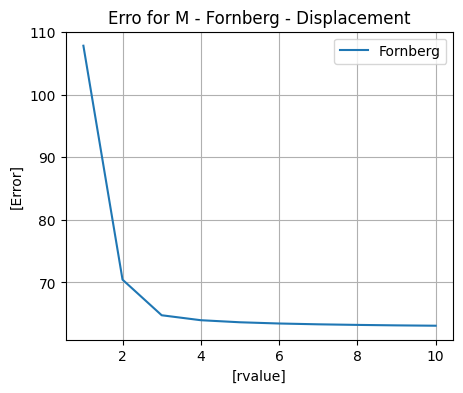

In [22]:
plt.figure(figsize = (5,4))
plt.plot(mvalues,lnormuf,label='Fornberg')
plt.grid()
plt.legend()
plt.title('Erro for M - Fornberg - Displacement')
plt.xlabel('[rvalue]')
plt.ylabel('[Error]')
plt.show()

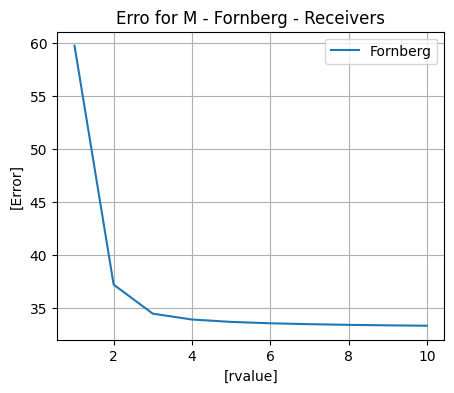

In [23]:
plt.figure(figsize = (5,4))
plt.plot(mvalues,lnormrecf,label='Fornberg')
plt.grid()
plt.legend()
plt.title('Erro for M - Fornberg - Receivers')
plt.xlabel('[rvalue]')
plt.ylabel('[Error]')
plt.show()

## 3. DPRS - Method 1

In [24]:
def objective(a):
    x = np.linspace(0, np.pi/2, 201)
    m = np.arange(1, len(a) + 1)
    y = x**2 + a[0] + 2*np.sum([a_ * np.cos(m_*x) for a_, m_ in zip(a[1:], m)], axis=0)
    return sp.integrate.trapezoid(y**2, x=x)

In [25]:
ludrp1   = []
lrecdrp1 = []
lrdrp1   = []

for k1 in range(0,nmavlues):

    M = k1+1
    x = [(1-(-1)**n*(2*n+1))//4 for n in range(2*M + 1)]
    N = 2
    weights     = sym.finite_diff_weights(N, x, 0)
    fornberg    = np.array(weights[-1][-1][::2], dtype=np.float64)
    
    initial_guess = fornberg
    
    constraints = [{
        'type': 'eq',
        'fun': lambda x: x[0] + 2*np.sum(x[1:])
    }]
    constraints += [{
        'type': 'eq',
        'fun': lambda x: np.sum([xi*m**2 for m, xi in enumerate(x)]) - 1
    }]
    constraints += [{
        'type': 'eq',
        'fun': lambda x: np.sum([xi*m**(2*jj) for m, xi in enumerate(x)])
    } for jj in range(2, (len(initial_guess) + 1)//2)]
    
    opt1 = sp.optimize.minimize(objective, initial_guess, method='SLSQP', constraints=constraints, options=dict(ftol=1e-15, maxiter=500))
    drp_stencil1 = opt1.x

    uf,dataf,rf = acoustic(drp_stencil1,h,dtnew,vval,f0,extent,t1)

    ludrp1.append(uf)
    lrecdrp1.append(dataf)
    lrdrp1.append(rf)
    critical_cfl(drp_stencil1,h,dtnew,vval)

Operator `Kernel` ran in 0.01 s


Limit Value: 0.816497
RVALUE: 0.300000
Stable Choice of weights,h,dt and vel!



Operator `Kernel` ran in 0.02 s


Limit Value: 0.690019
RVALUE: 0.300000
Stable Choice of weights,h,dt and vel!



Operator `Kernel` ran in 0.02 s


Limit Value: 0.653884
RVALUE: 0.300000
Stable Choice of weights,h,dt and vel!



Operator `Kernel` ran in 0.02 s


Limit Value: 0.638710
RVALUE: 0.300000
Stable Choice of weights,h,dt and vel!



Operator `Kernel` ran in 0.03 s


Limit Value: 0.625809
RVALUE: 0.300000
Stable Choice of weights,h,dt and vel!



Operator `Kernel` ran in 0.03 s


Limit Value: 0.630542
RVALUE: 0.300000
Stable Choice of weights,h,dt and vel!



Operator `Kernel` ran in 0.04 s


Limit Value: 0.623438
RVALUE: 0.300000
Stable Choice of weights,h,dt and vel!



Operator `Kernel` ran in 0.04 s


Limit Value: 0.617750
RVALUE: 0.300000
Stable Choice of weights,h,dt and vel!



Operator `Kernel` ran in 0.05 s


Limit Value: 0.613151
RVALUE: 0.300000
Stable Choice of weights,h,dt and vel!



Operator `Kernel` ran in 0.06 s


Limit Value: 0.609340
RVALUE: 0.300000
Stable Choice of weights,h,dt and vel!



In [26]:
lnormudrp1   = []
lnormrecdrp1 = []

for k0 in range(0,nmavlues):
    
    difu   = luref[0] - ludrp1[k0]
    lnormu = la.norm(difu,normtype)/la.norm(luref[0],normtype)

    difrec   = lrecref[0] - lrecdrp1[k0]
    lnormrec = la.norm(difrec,normtype)/la.norm(lrecref[0],normtype)
    
    ctedt = np.sqrt(16/1)
    ctedx = 16/1
    cte   = ctedt*ctedx
    
    lnormudrp1.append(cte*lnormu)
    lnormrecdrp1.append(cte*lnormrec)

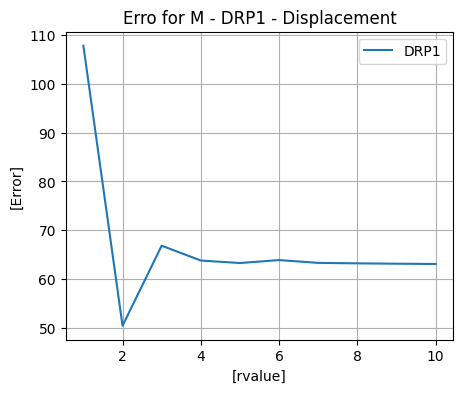

In [27]:
plt.figure(figsize = (5,4))
plt.plot(mvalues,lnormudrp1,label='DRP1')
plt.grid()
plt.legend()
plt.title('Erro for M - DRP1 - Displacement')
plt.xlabel('[rvalue]')
plt.ylabel('[Error]')
plt.show()

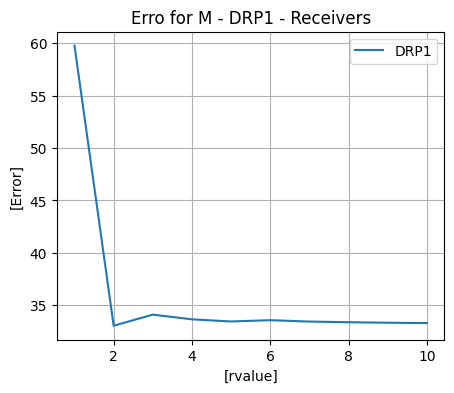

In [28]:
mvalues = [1,2,3,4,5,6,7,8,9,10]
plt.figure(figsize = (5,4))
plt.plot(mvalues,lnormrecdrp1,label='DRP1')
plt.grid()
plt.legend()
plt.title('Erro for M - DRP1 - Receivers')
plt.xlabel('[rvalue]')
plt.ylabel('[Error]')
plt.show()

## 4.DRPS - Method 2

In [29]:
def dispersion_difference(weights, h, dt, v, k, alpha):
    if k == 0:
        diff = 0
    else:
        m = len(weights)
        cosines = np.array([
            np.cos(m*k*h*np.cos(alpha)) + np.cos(m*k*h*np.sin(alpha)) - 2
            for m in range(1, m)
        ])
        total = np.sum(np.array(weights)[1:]*cosines)
        theta = 1 + (v**2)*(dt**2)*total/(h**2)
        diff = np.abs(np.acos(theta)/(k*dt) - v)
    return diff

In [30]:
def objective2(a, h, dt, fmax=100, vmin=1500, vmax=5500, alphamin=0, alphamax=np.pi/4, res=31):
    diff_wrapper = partial(dispersion_difference, weights=a, h=h, dt=dt)

    k_integral = np.zeros(res)
    v_space = np.linspace(vmin, vmax, res)
    alpha_space = np.linspace(alphamin, alphamax, res)
    for ii, v in enumerate(v_space):
        alpha_integral = np.zeros(res)
        k_space = np.linspace(0, 2*np.pi*fmax/v, res)
        for jj, k in enumerate(k_space):
            alpha_data = np.array([
                diff_wrapper(alpha=alpha, k=k, v=v) for alpha in alpha_space
            ])
            alpha_integral[jj] = np.trapezoid(alpha_data, alpha_space)
        k_integral[ii] = np.trapezoid(alpha_integral, k_space)
    v_integral = np.trapezoid(k_integral, v_space)

    return v_integral

In [31]:
ludrp2   = []
lrecdrp2 = []
lrdrp2   = []

for k1 in range(0,nmavlues):

    M = k1+1
    x = [(1-(-1)**n*(2*n+1))//4 for n in range(2*M + 1)]
    N = 2
    weights     = sym.finite_diff_weights(N, x, 0)
    fornberg    = np.array(weights[-1][-1][::2], dtype=np.float64)
    
    initial_guess = fornberg
    
    objective2_wrapper = partial(objective2, h=h, dt=dtnew)
    opt2 = sp.optimize.minimize(objective2_wrapper, initial_guess, constraints=constraints, method='SLSQP')
    drp_stencil2 = opt2.x
    uf,dataf,rf = acoustic(drp_stencil2,h,dtnew,vval,f0,extent,t1)

    ludrp2.append(uf)
    lrecdrp2.append(dataf)
    lrdrp2.append(rf)
    critical_cfl(drp_stencil2,h,dtnew,vval)

Operator `Kernel` ran in 0.02 s


Limit Value: 0.816497
RVALUE: 0.300000
Stable Choice of weights,h,dt and vel!



Operator `Kernel` ran in 0.02 s


Limit Value: 0.714590
RVALUE: 0.300000
Stable Choice of weights,h,dt and vel!



Operator `Kernel` ran in 0.02 s


Limit Value: 0.675480
RVALUE: 0.300000
Stable Choice of weights,h,dt and vel!



Operator `Kernel` ran in 0.02 s


Limit Value: 0.654112
RVALUE: 0.300000
Stable Choice of weights,h,dt and vel!



Operator `Kernel` ran in 0.03 s


Limit Value: 0.640385
RVALUE: 0.300000
Stable Choice of weights,h,dt and vel!



Operator `Kernel` ran in 0.03 s


Limit Value: 0.630701
RVALUE: 0.300000
Stable Choice of weights,h,dt and vel!



Operator `Kernel` ran in 0.03 s


Limit Value: 0.623438
RVALUE: 0.300000
Stable Choice of weights,h,dt and vel!



Operator `Kernel` ran in 0.04 s


Limit Value: 0.617750
RVALUE: 0.300000
Stable Choice of weights,h,dt and vel!



Operator `Kernel` ran in 0.05 s


Limit Value: 0.613151
RVALUE: 0.300000
Stable Choice of weights,h,dt and vel!



Operator `Kernel` ran in 0.06 s


Limit Value: 0.609340
RVALUE: 0.300000
Stable Choice of weights,h,dt and vel!



In [32]:
lnormudrp2   = []
lnormrecdrp2 = []

for k0 in range(0,nmavlues):
    
    difu   = luref[0] - ludrp2[k0]
    lnormu = la.norm(difu,normtype)/la.norm(luref[0],normtype)

    difrec   = lrecref[0] - lrecdrp2[k0]
    lnormrec = la.norm(difrec,normtype)/la.norm(lrecref[0],normtype)

    ctedt = np.sqrt(16/1)
    ctedx = 16/1
    cte   = ctedt*ctedx
    
    lnormudrp2.append(cte*lnormu)
    lnormrecdrp2.append(cte*lnormrec)

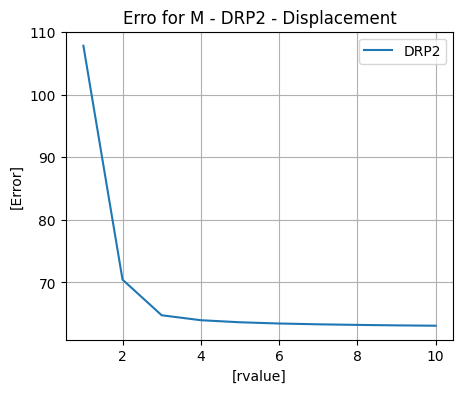

In [33]:
plt.figure(figsize = (5,4))
plt.plot(mvalues,lnormudrp2,label='DRP2')
plt.grid()
plt.legend()
plt.title('Erro for M - DRP2 - Displacement')
plt.xlabel('[rvalue]')
plt.ylabel('[Error]')
plt.show()

Text(0, 0.5, '[Error]')

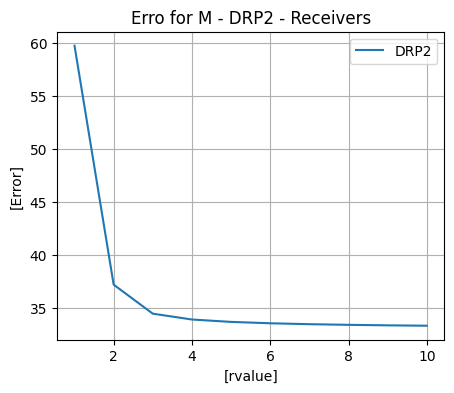

In [34]:
plt.figure(figsize = (5,4))
plt.plot(mvalues,lnormrecdrp2,label='DRP2')
plt.grid()
plt.legend()
plt.title('Erro for M - DRP2 - Receivers')
plt.xlabel('[rvalue]')
plt.ylabel('[Error]')

## 5. Comparison

In [35]:
lnormuf

[np.float64(107.84102785544718),
 np.float64(70.44865923539926),
 np.float64(64.75645433648037),
 np.float64(63.96431279040735),
 np.float64(63.63457963208943),
 np.float64(63.439005681243344),
 np.float64(63.30861093008276),
 np.float64(63.2147007293116),
 np.float64(63.13955554361231),
 np.float64(63.08383285197495)]

In [36]:
lnormudrp1

[np.float64(107.84102785544718),
 np.float64(50.42279150315021),
 np.float64(66.83178724680994),
 np.float64(63.79109105814012),
 np.float64(63.28018224993614),
 np.float64(63.886178108198514),
 np.float64(63.30861093008276),
 np.float64(63.2147007293116),
 np.float64(63.13955554361231),
 np.float64(63.08383285197495)]

In [37]:
lnormudrp2

[np.float64(107.84102785544718),
 np.float64(70.44865923539926),
 np.float64(64.75645433648037),
 np.float64(63.96431279040735),
 np.float64(63.63457963208943),
 np.float64(63.439005681243344),
 np.float64(63.30861093008276),
 np.float64(63.2147007293116),
 np.float64(63.13955554361231),
 np.float64(63.08383285197495)]

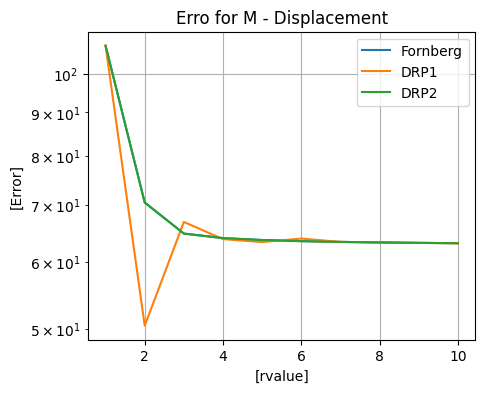

In [38]:
plt.figure(figsize = (5,4))
plt.plot(mvalues,lnormuf,label='Fornberg')
plt.plot(mvalues,lnormudrp1,label='DRP1')
plt.plot(mvalues,lnormudrp2,label='DRP2')
plt.grid()
plt.legend()
plt.title('Erro for M - Displacement')
plt.xlabel('[rvalue]')
plt.ylabel('[Error]')
plt.yscale('log')
plt.show()

In [39]:
lnormrecf

[np.float64(59.77672523864989),
 np.float64(37.17372350914245),
 np.float64(34.426929017209126),
 np.float64(33.87521326051193),
 np.float64(33.64892345692757),
 np.float64(33.51917500473906),
 np.float64(33.43295844032726),
 np.float64(33.37104024494981),
 np.float64(33.32368899847325),
 np.float64(33.28740098166589)]

In [40]:
lnormrecdrp1

[np.float64(59.77672523864989),
 np.float64(33.03718607937721),
 np.float64(34.097941385654096),
 np.float64(33.647247728353754),
 np.float64(33.44254057695414),
 np.float64(33.56625320589382),
 np.float64(33.43295844032726),
 np.float64(33.37104024494981),
 np.float64(33.32368899847325),
 np.float64(33.28740098166589)]

In [41]:
lnormrecdrp2

[np.float64(59.77672523864989),
 np.float64(37.17372350914245),
 np.float64(34.426929017209126),
 np.float64(33.87521326051193),
 np.float64(33.64892345692757),
 np.float64(33.51917500473906),
 np.float64(33.43295844032726),
 np.float64(33.37104024494981),
 np.float64(33.32368899847325),
 np.float64(33.28740098166589)]

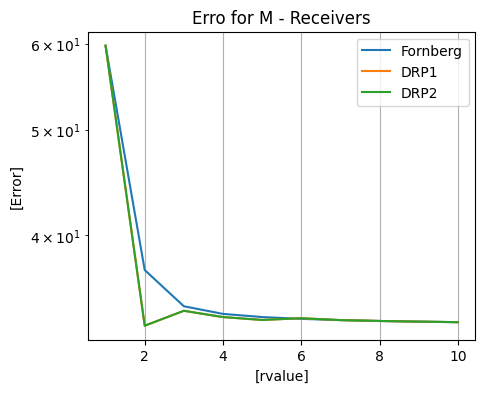

In [42]:
plt.figure(figsize = (5,4))
plt.plot(mvalues,lnormrecf,label='Fornberg')
plt.plot(mvalues,lnormrecdrp1,label='DRP1')
plt.plot(mvalues,lnormrecdrp1,label='DRP2')
plt.grid()
plt.legend()
plt.title('Erro for M - Receivers')
plt.xlabel('[rvalue]')
plt.ylabel('[Error]')
plt.yscale('log')
plt.show()